# The Power Law Residual Ratio V2
This is the code implementation of the Power Law Residual Ratio v2 introduced in [article](https://www.temonet.com/posts/power-law-residual-ratio-v2/).

In [26]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from scipy.interpolate import interp1d

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# Read file
bitcoinPriceData = pd.read_csv('bitcoin_historical_Oct2024.csv')

priceFull = bitcoinPriceData[['Open', 'High', 'Low', 'Close']][::-1].to_numpy()
timeFull = pd.to_datetime(bitcoinPriceData['Start'][::-1].to_numpy())
price_df = pd.DataFrame(priceFull, index=timeFull, columns=['Open', 'High', 'Low', 'Close'])
price_df.index.name = 'Date'



# Set parameters --------------
t0 = '2009-01-03' # Bitcoin genesis date
start_date = '2014-06-01' # Start date for retrieving price data
end_date = (datetime.today() + pd.to_timedelta(1, unit='D')).strftime('%Y-%m-%d') # End date for retrieving price data
k_PL = 5.7 # Power Law Exponent
T_span = np.arange(180,451,15)  # Time span in days for calculating PLRR
ticker_name = 'BTC-USD' # ticker name for bitcoin price


# Convert t0 to datetime
t0_datetime = pd.to_datetime(t0)

# Calculate timeDays by subtracting t0 from the index
price_df['TimeDays'] = (price_df.index - t0_datetime).days
# Calculate daily log Return
price_df['LogReturn'] = np.log(0.5*(price_df['High']+price_df['Low'])).diff()
# Calculate daily log time difference
price_df['LogTimeDiff'] = np.log(price_df['TimeDays']).diff()


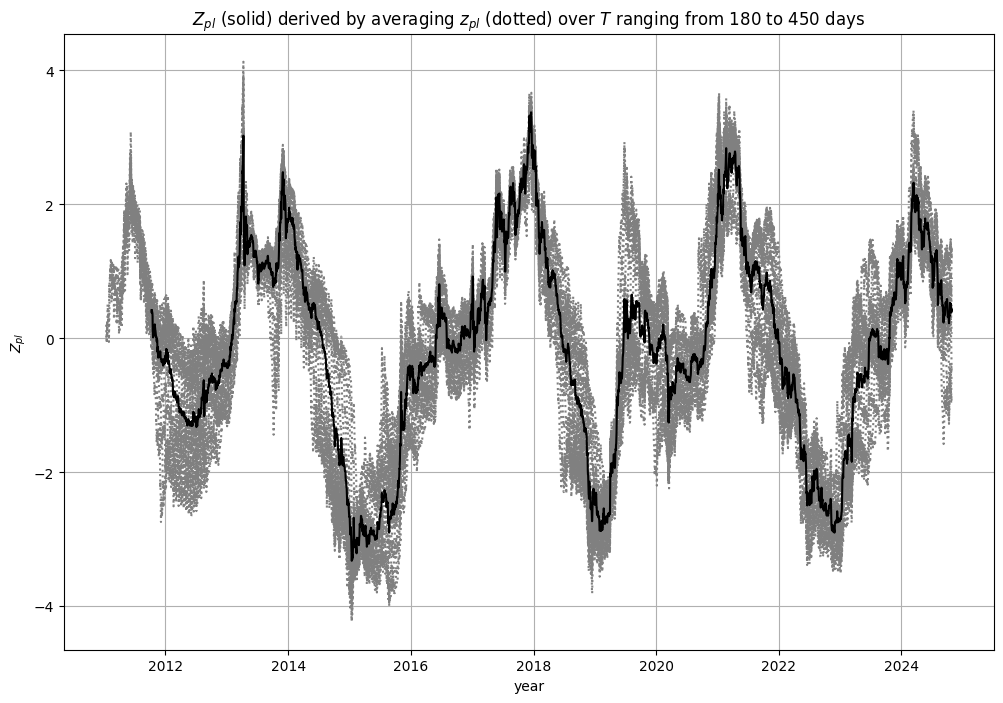

In [27]:
#Perform Time Period Averaging.

price_df['Zpl'] = np.zeros(len(price_df))
plt.figure(figsize=(12, 8))
for jj in np.arange(0,len(T_span)):
    # Calculate rolling mean to log Return
    price_df['MeanLogReturn'] = price_df['LogReturn'].rolling(T_span[jj]).mean()
    # Apply rolling mean to log time difference
    price_df['MeanLogTimeDiff'] = price_df['LogTimeDiff'].rolling(T_span[jj]).mean()
    # Calculate rolling standard deviation
    price_df['LogSDev'] = price_df['LogReturn'].rolling(T_span[jj]).std()
    # Calculate Power Law Residual Ratio with scaling definition 1 (value)
    price_df['Zpl'] += (1/len(T_span))*np.sqrt(T_span[jj])*(price_df['MeanLogReturn'] - k_PL*price_df['MeanLogTimeDiff'])/price_df['LogSDev']
    PLRR_curr = np.sqrt(T_span[jj])*(price_df['MeanLogReturn'] - k_PL*price_df['MeanLogTimeDiff'])/price_df['LogSDev']
    plt.plot(price_df.index, PLRR_curr,color = 'gray',linestyle = ':')

plt.plot(price_df.index,price_df['Zpl'],color='black')
plt.grid(True)
plt.xlabel('year')
plt.ylabel('$Z_{pl}$')
plt.title('$Z_{pl}$ (solid) derived by averaging $z_{pl}$ (dotted) over $T$ ranging from ' +str(T_span[0]) +' to '+str(T_span[-1])+' days')
plt.show()




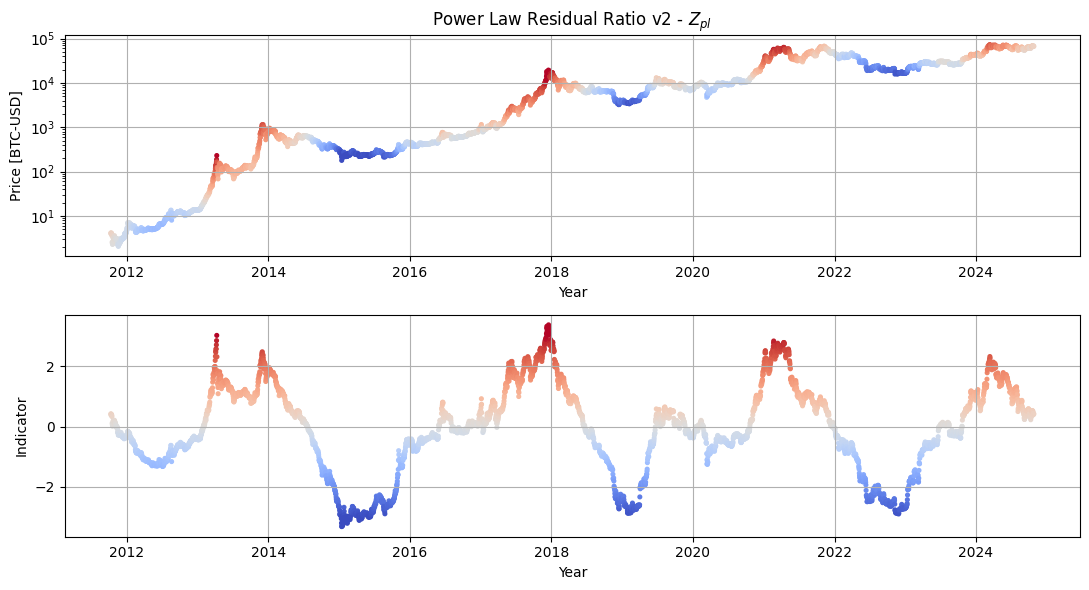

In [28]:
# Normalize the color map
norm = mcolors.Normalize(vmin=-3, vmax=3)
cmap = plt.get_cmap('coolwarm')

# Apply color gradient
colors = cmap(norm((price_df['Zpl'])))
plt.figure(figsize=(11, 6), facecolor='white')
plt.subplot(211)
ax1 = plt.gca()
plt.title('Power Law Residual Ratio v2 - $Z_{pl}$')
plt.scatter(price_df.index[T_span[-1]:],price_df['Close'][T_span[-1]:], c=colors[T_span[-1]:], s=7)
plt.yscale('log')
plt.grid(True)


plt.xlabel('Year', color='black')
plt.ylabel('Price [BTC-USD]', color='black')

plt.subplot(212)
ax2 = plt.gca()
plt.scatter(price_df.index, price_df['Zpl'], c=colors, s=7)
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Indicator')
plt.tight_layout()
plt.show()
